# Import GTFS into Quetzal
1. Load GTFS data
2. Explore GTFS data
3. Filter relevant modeling inputs
4. Build links and nodes and export into a Quetzal model

In [1]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# START

In [2]:
import sys
sys.path.insert(0, r'../../../quetzal')

from quetzal.io.gtfs_reader import importer
import geopandas as gpd
from shapely import geometry
from quetzal.model import stepmodel

if manual:
    %matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]

C:\Users\rgoix\AppData\Local\Continuum\anaconda3\envs\quetzal_env\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


SQLalchemy is not installed. No support for SQL output.


In [3]:
training_folder = '../../'
input_folder = training_folder + r'inputs/'

In [4]:
zones = gpd.read_file(r'../../inputs/zones/zones.geojson')
hull = geometry.MultiPolygon(zones['geometry'].values).buffer(1e-3)

The file importer of quetzal contains a main class: GtfsImporter  
It gives access to different method to handle GTFS data:
- description (GtfsImporter.describe())
- maps
- filtering on specific area, dates, trips, stops (GtfsImporter.restrict())
- stops / trips aggregation
- frequency conversion

In [5]:
full_feed = importer.GtfsImporter(path=input_folder + r'/IDFM_gtfs.zip', dist_units='m') 
# downloaded from https://data.iledefrance-mobilites.fr/explore/dataset/offre-horaires-tc-gtfs-idf/table/

In [9]:
full_feed.describe()

indicator                                              value
0          agencies  [Seine Essonne Bus, Pays de Meaux, Pays de Mea...
1  running_services  [1968, 5723, 1141, 3733, 2293, 2963, 3486, 603...
2          timezone                                       Europe/Paris
3        start_date                                           20200129
4          end_date                                           20200223
5        num_routes                                               1874
6         num_trips                                             452369
7         num_stops                                              63462
8        num_shapes                                                  0
9   num_frequencies                                                  0

In [10]:
full_feed.map_stops(stop_ids=full_feed.stops['stop_id'])

Adapt GTFS to model needs: one specific service during a given time period

In [11]:
feed_r = full_feed.restrict(
    dates=['20200204'] # the dates must be within the feed start and end dates
)

In [12]:
time_range = ['08:00:00', '09:00:00'] 
feed_t = feed_r.restrict(time_range=time_range)

In [13]:
feed_t.stop_times.head()

trip_id arrival_time departure_time            stop_id  \
620  109139375-1_454297     07:46:00       07:46:00  StopPoint:94:1312   
621  109139375-1_454297     07:50:00       07:50:00  StopPoint:94:1328   
622  109139375-1_454297     07:52:00       07:52:00  StopPoint:94:1348   
623  109139375-1_454297     07:53:00       07:53:00  StopPoint:94:1358   
624  109139375-1_454297     07:55:00       07:55:00  StopPoint:94:1446   

     stop_sequence  stop_time_desc  pickup_type  drop_off_type  
620              0             NaN            0              0  
621              1             NaN            0              0  
622              2             NaN            0              0  
623              3             NaN            0              0  
624              4             NaN            0              0

In [14]:
def spatial_restrict(feed, polygon, how='inner'):
    f = feed.copy()
    stops = f.stops.copy()
    stops['geometry'] = stops.apply(
        lambda r: geometry.Point([r['stop_lon'], r['stop_lat']]),
        axis=1
    )
    stops['included'] = stops['geometry'].apply(lambda g: polygon.contains(g))
    f.stops = f.stops.loc[stops['included'] == True]

    # relations
    f.stop_times = f.stop_times.loc[f.stop_times['stop_id'].isin(f.stops['stop_id'])]
    f.transfers = f.transfers.loc[f.transfers['from_stop_id'].isin(f.stops['stop_id'])]
    f.transfers = f.transfers.loc[f.transfers['to_stop_id'].isin(f.stops['stop_id'])]
    relevant_trips = (f.stop_times['trip_id'])
    f = f.restrict(trip_ids=relevant_trips)
    if how == 'inner':
        return f
    else:
        return feed.restrict(trip_ids=relevant_trips)

In [15]:
feed_s = spatial_restrict(feed_t, polygon=hull, how='inner')

In [19]:
feed_s.group_services()

In [18]:
feed_s.map_stops(feed_s.stops.stop_id)

Aggregating trips and stops into patterns

In [48]:
feed = feed_s.copy()

In [49]:
feed.build_stop_clusters(distance_threshold=300)  # Automatically geometrize stops into UTM: meters are relevant
feed.build_patterns(on='cluster_id')

By testing different distance thresholds up to 1000m, analyze the impact on the number of stop clusters and the number of patterns

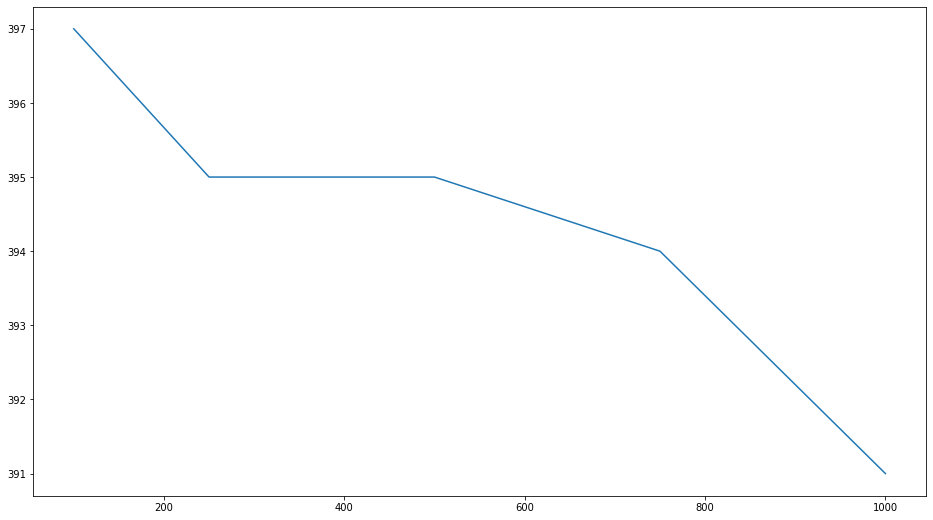

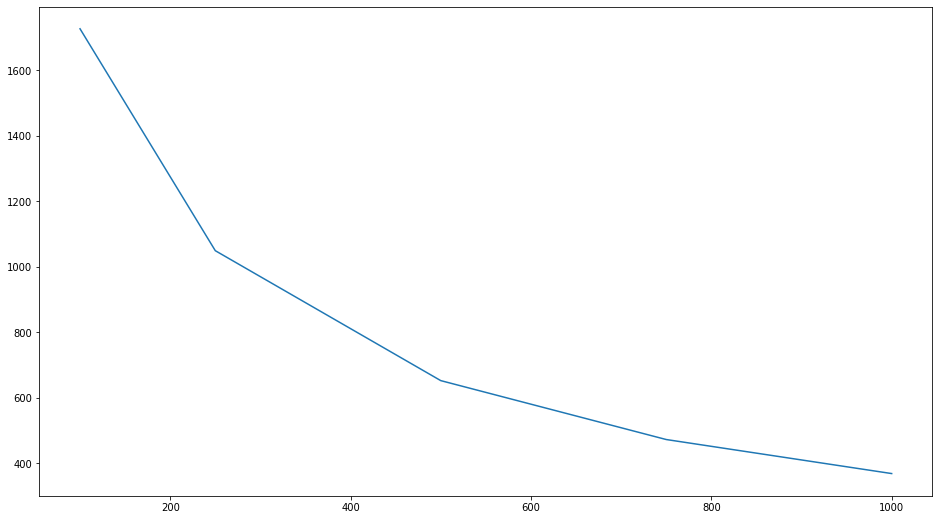

In [36]:
distances = [100,250,500,750,1000]
n_patterns = []
n_clusters = []
for d in distances:
    feed = feed_s.copy()
    feed.build_stop_clusters(distance_threshold=d)  # Automatically geometrize stops into UTM: meters are relevant
    feed.build_patterns(on='cluster_id')
    n_p = len(feed.trips['pattern_id'].unique())
    n_c = len(feed.stops['cluster_id'].unique())
    n_clusters.append(n_c)
    n_patterns.append(n_p)
plt.plot(distances, n_patterns)
plt.show()
plt.plot(distances, n_clusters)

In [50]:
feed_frequencies = feed.convert_to_frequencies(time_range=time_range)  # by default on pattern_id column

100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:36<00:00, 10.62it/s]


In [59]:
feed_frequencies.frequencies

trip_id  headway_secs start_time  end_time
1        010010007:108_1         720.0   08:00:00  09:00:00
3        010010007:109_1        3600.0   08:00:00  09:00:00
5      055155001:DM151_1         400.0   08:00:00  09:00:00
6    098098001:DIRECT1_0        1200.0   08:00:00  09:00:00
7    098098001:DIRECT1_1        1200.0   08:00:00  09:00:00
..                   ...           ...        ...       ...
385      800:TER:Train_7        1200.0   08:00:00  09:00:00
386              810:A_0          88.0   08:00:00  09:00:00
387              810:A_1          82.0   08:00:00  09:00:00
388              810:B_0         180.0   08:00:00  09:00:00
389              810:B_1          90.0   08:00:00  09:00:00

[363 rows x 4 columns]

## Build links and nodes

In [70]:
feed_frequencies.build_links_and_nodes()
feed_frequencies.build_geometries(use_utm=False)

In [72]:
feed_frequencies.links.head(1)

index                   a              trip_id  link_sequence  \
0      0  StopPoint:14:14934  098098001:DIRECT1_0              1   

   departure_time                   b  arrival_time   time  headway  \
0         27600.0  StopPoint:14:14976       27900.0  300.0   1200.0   

            pattern_id  ... shape_id agency_id route_short_name  \
0  098098001:DIRECT1_0  ...      NaN       896         DIRECT 1   

   route_long_name  route_desc  route_type  route_url  route_color  \
0  LE BUS DIRECT 1         NaN           3        NaN       B20066   

   route_text_color                                         geometry  
0            ffffff  LINESTRING (2.29451 48.87432, 2.28651 48.86277)  

[1 rows x 29 columns]

In [74]:
feed_frequencies.nodes.head(1)

stop_id      stop_name stop_desc zone_id stop_url  \
315  StopArea:8738102  PORTE MAILLOT       NaN     NaN      NaN   

     location_type parent_station  wheelchair_boarding  cluster_id  \
315              1            NaN                  NaN          86   

                     geometry  
315  POINT (2.28258 48.87812)

# rename route types

In [75]:
mapping = {0:'tram', 1:'subway', 2:'rail', 3:'bus',
    4:'ferry', 5:'cable_car', 6:'gondola', 7:'funicular'}

feed_frequencies.links['route_type'] = feed_frequencies.links['route_type'].apply(
    lambda t: mapping.get(t, t)
)

# export 

We create a quetzal stepmodel object, containing the links, nodes and zones

In [77]:
sm = stepmodel.StepModel(epsg=4326, coordinates_unit='degree')
sm.links = feed_frequencies.links
sm.nodes = feed_frequencies.nodes#[['geometry', 'stop_id', 'stop_name', 'location_type']]
sm.zones = zones

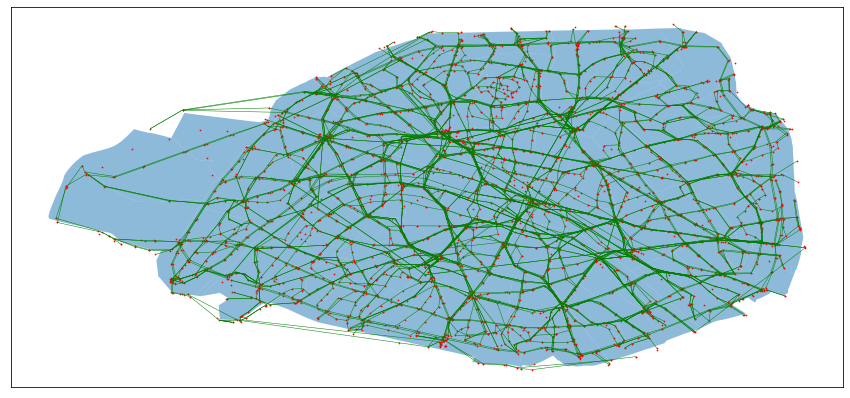

In [78]:
ax = sm.plot('zones', alpha=0.5, figsize=[17, 7])
ax = sm.plot('links', linewidth=0.5, color='green', ax=ax)
plot = sm.plot('nodes', markersize=0.5, color='red', ax=ax)

In [79]:
sm.to_json(input_folder + 'gtfs', only_attributes=['links', 'nodes'])

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 32/32 [00:16<00:00,  1.99it/s]


Display links and nodes in a GIS software

In [80]:
sm.to_zip(training_folder + r'model/base/base.zip')

to_hdf(new file): 100%|████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00,  9.49it/s]


# END